In [1]:
import sys
import sqlite3
import pandas as pd
import numpy as np
import pylab
import math
from sklearn.preprocessing import LabelEncoder

In [2]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.



def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 120
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y * 100



In [3]:
con = sqlite3.connect("track_metadata.db")
df = pd.read_sql_query("SELECT * from songs", con)

In [4]:
df.head(5)

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


In [5]:
df['decade'] = df['year'] / 5.0
df['decade'] = df['decade'].apply(np.floor)
df['decade'] = df['decade']*5.0

df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work,decade
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0,2000.0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0,1995.0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0,2005.0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0,2000.0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0,0.0


In [6]:
df_nonzero = df[df['year']!= 0].copy()
df_nonzero = df_nonzero[['artist_id','year','decade']]

In [7]:
df_nz_max = df_nonzero.groupby(['artist_id','decade']).count()
#df_nz_max = df_nonzero.groupby('artist_id').min()

In [8]:
df_nz_max.groupby(['artist_id','decade'], sort=False)['year'].max().to_frame()

year
artist_id          decade      
AR002UA1187B9A637D 2000.0     9
AR009211187B989185 2005.0     2
AR009SZ1187B9A73F4 1995.0     1
                   2000.0     5
AR00A1N1187FB484EB 1985.0     1
...                         ...
ARZZXJY1187B99E2BB 1995.0     3
ARZZXT51187FB4627E 1965.0    19
                   1990.0     1
                   2005.0     2
ARZZYRH11C8A416A12 2005.0     6

[55578 rows x 1 columns]

In [9]:
noo = df_nz_max.loc[df_nz_max.groupby(['artist_id'])['year'].idxmax()]

In [10]:
con = sqlite3.connect("artist_term2.db")
df_AT = pd.read_sql_query("SELECT * FROM artist_term", con)

In [11]:
df_AT.head(10)

,artist_id,term
0,AR002UA1187B9A637D,garage rock
1,AR002UA1187B9A637D,country rock
2,AR002UA1187B9A637D,free jazz
3,AR002UA1187B9A637D,oi
4,AR002UA1187B9A637D,space rock
5,AR002UA1187B9A637D,power pop
6,AR002UA1187B9A637D,indie rock
7,AR002UA1187B9A637D,reggae
8,AR002UA1187B9A637D,pop rock
9,AR002UA1187B9A637D,rock


In [12]:
artists = df_AT['artist_id'].unique()
artist_list = artists.tolist()

In [13]:
termer = df_AT.groupby('term').count().reset_index().sort_values('artist_id',ascending=False)

In [14]:
len(termer)

7643

In [64]:
term_200 = termer.head(200).copy()

In [65]:
term_100 = termer.head(100).copy()

In [66]:
terms = term_200['term'].unique()
terms_list = terms.tolist()

terms_100 = term_100['term'].unique()
terms_list_100 = terms_100.tolist()

In [17]:
df_wcols = df_AT.copy()

In [18]:
for x in terms_list:
    df_wcols[x] = 0
df_wcols.columns

Index(['artist_id', 'term', 'rock', 'electronic', 'pop', 'alternative rock',
       'hip hop', 'united states', 'house', 'jazz',
       ...
       'political', 'comedy', 'hardcore punk', 'old school', 'deep',
       'female vocals', 'gospel', 'garage', 'london', 'free jazz'],
      dtype='object', length=202)

In [19]:
for term in terms_list:

    df_wcols[term] = np.where((df_wcols['term']==term), 1, df_wcols[term])

In [20]:
len(df_wcols)

1109381

In [21]:
df_byartist = df_wcols.groupby('artist_id').sum()

In [22]:
df_for_later = df_byartist.copy()

In [23]:
df_for_later

,rock,electronic,pop,alternative rock,hip hop,united states,house,jazz,alternative,indie,...,political,comedy,hardcore punk,old school,deep,female vocals,gospel,garage,london,free jazz
artist_id,,,,,,,,,,,,,,,,,,,,,
AR002UA1187B9A637D,1,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
AR003FB1187B994355,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AR006821187FB5192B,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AR009211187B989185,1,1,1,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AR009SZ1187B9A73F4,1,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ARZZXJY1187B99E2BB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARZZXT51187FB4627E,1,1,1,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
ARZZYRB1187B99D0B6,1,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_byartist['total_terms'] = 0

In [25]:
for x in terms_list:
    df_byartist['total_terms'] += df_byartist[x]

In [26]:
noo = noo.reset_index()

In [27]:
df_byartist = df_byartist.merge(noo, on='artist_id',how='left')

In [28]:
df_byartist = df_byartist.dropna()

In [29]:
df_byartist['total_terms'].max()

69

In [30]:
df_byart_fm = df_byartist[(df_byartist['total_terms']>=30)&(df_byartist['total_terms']<50)].copy()

In [31]:
df_byart_fm

,artist_id,rock,electronic,pop,alternative rock,hip hop,united states,house,jazz,alternative,...,old school,deep,female vocals,gospel,garage,london,free jazz,total_terms,decade,year
8,AR00B1I1187FB433EB,1,1,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,45,2000.0,25.0
9,AR00DDV1187B98B2BF,1,1,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,34,2000.0,4.0
24,AR00P3M1187FB5428C,0,1,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,33,1995.0,12.0
27,AR00RBU1187B9B3F1F,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,30,2000.0,12.0
33,AR014T71187B9B8756,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,34,2005.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43912,ARZZGL61187FB3E003,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,41,1995.0,14.0
43914,ARZZGUT1187B9ACB5C,1,1,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,33,2005.0,2.0
43918,ARZZLLI1187B99C8DD,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,45,2005.0,12.0
43933,ARZZRK91187B9A5CA5,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,31,1965.0,10.0


In [32]:
df_count_tags = df_byart_fm.copy()
df_count_tags = df_count_tags.drop('artist_id',axis=1)

In [33]:
for_X = df_byart_fm.drop(['artist_id','total_terms','year','year','decade'],axis=1)

In [34]:
for_X

,rock,electronic,pop,alternative rock,hip hop,united states,house,jazz,alternative,indie,...,political,comedy,hardcore punk,old school,deep,female vocals,gospel,garage,london,free jazz
8,1,1,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24,0,1,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
27,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
33,1,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43912,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
43914,1,1,0,0,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
43918,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
43933,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
for_labels = df_byart_fm[['decade']]

In [36]:
len(for_labels['decade'].unique())

14

In [37]:
X = for_X.to_numpy()

In [38]:
X.shape

(6658, 200)

In [39]:
for_X

,rock,electronic,pop,alternative rock,hip hop,united states,house,jazz,alternative,indie,...,political,comedy,hardcore punk,old school,deep,female vocals,gospel,garage,london,free jazz
8,1,1,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24,0,1,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
27,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
33,1,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43912,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
43914,1,1,0,0,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
43918,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
43933,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X.shape

(6658, 200)

In [71]:
X_100 = X[:,:100]
X_100.shape

(6658, 100)

In [41]:
labels = for_labels.to_numpy()

# BEGIN ARTIST TAG INTAKE

In [42]:
artist_df = pd.read_csv('artist_term.csv', header=None)
artist_df = artist_df.rename({0:'artist_id',1:'tag'},axis=1)
artist_df

,artist_id,tag
0,AR5DF6K1187B98F545,70s
1,AR5DF6K1187B98F545,90s
2,AR5DF6K1187B98F545,alternative rock
3,AR5DF6K1187B98F545,bubblegum dance
4,AR5DF6K1187B98F545,dance
...,...,...
299995,ARSJUTZ1187B9B4DFC,mangue beat
299996,ARSJUTZ1187B9B4DFC,pop
299997,ARSJUTZ1187B9B4DFC,rap
299998,ARSJUTZ1187B9B4DFC,rap rock


In [43]:
df_for_later.reset_index(inplace=True)

In [44]:
le = LabelEncoder()
df_for_later['artist_id'] = le.fit_transform(df_for_later['artist_id'])

In [45]:
df_for_later

,artist_id,rock,electronic,pop,alternative rock,hip hop,united states,house,jazz,alternative,...,political,comedy,hardcore punk,old school,deep,female vocals,gospel,garage,london,free jazz
0,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
1,1,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43938,43938,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43939,43939,1,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
43940,43940,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
43941,43941,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df_for_later['total_terms'] = 0

In [47]:
for x in terms_list:
    df_for_later['total_terms'] += df_for_later[x]

In [48]:
df_for_later.sum()

artist_id           965471653
rock                    27274
electronic              24073
pop                     19637
alternative rock        15374
                      ...    
gospel                   1161
garage                   1155
london                   1154
free jazz                1145
total_terms            780131
Length: 202, dtype: int64

In [49]:
limited_arts = df_for_later[df_for_later['total_terms']>25].copy()

In [50]:
limited_arts = limited_arts.drop(['rock','pop','electronic','alternative rock'],axis=1)

In [51]:
limited_arts.sum()

artist_id        234165331
hip hop               7142
united states         5165
house                 6200
jazz                  6058
                   ...    
gospel                 304
garage                 391
london                 466
free jazz              685
total_terms         386476
Length: 198, dtype: int64

In [52]:
#limited_arts = limited_arts.sample(1000)

In [53]:
limited_arts.columns

Index(['artist_id', 'hip hop', 'united states', 'house', 'jazz', 'alternative',
       'indie', 'electro', 'experimental', 'indie rock',
       ...
       'comedy', 'hardcore punk', 'old school', 'deep', 'female vocals',
       'gospel', 'garage', 'london', 'free jazz', 'total_terms'],
      dtype='object', length=198)

In [54]:
limited_arts_drp = limited_arts.drop(['artist_id','total_terms'], axis=1)
limited_arts_drp

,hip hop,united states,house,jazz,alternative,indie,electro,experimental,indie rock,pop rock,...,political,comedy,hardcore punk,old school,deep,female vocals,gospel,garage,london,free jazz
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
9,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43921,1,1,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
43923,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
43932,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
43933,1,1,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [55]:
artist_labels = limited_arts['artist_id'].to_numpy()

In [56]:
artist_labels

array([    2,     3,     5, ..., 43932, 43933, 43939])

In [57]:
X_artists = limited_arts_drp.to_numpy()
X_artists

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [58]:
X_artists.shape

(11052, 196)

### Broad set, 200 features

Running graph for individual artist similarities
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 11052...
Computing P-values for point 500 of 11052...
Computing P-values for point 1000 of 11052...
Computing P-values for point 1500 of 11052...
Computing P-values for point 2000 of 11052...
Computing P-values for point 2500 of 11052...
Computing P-values for point 3000 of 11052...
Computing P-values for point 3500 of 11052...
Computing P-values for point 4000 of 11052...
Computing P-values for point 4500 of 11052...
Computing P-values for point 5000 of 11052...
Computing P-values for point 5500 of 11052...
Computing P-values for point 6000 of 11052...
Computing P-values for point 6500 of 11052...
Computing P-values for point 7000 of 11052...
Computing P-values for point 7500 of 11052...
Computing P-values for point 8000 of 11052...
Computing P-values for point 8500 of 11052...
Computing P-values for point 9000 of 11052...
Computing P-v

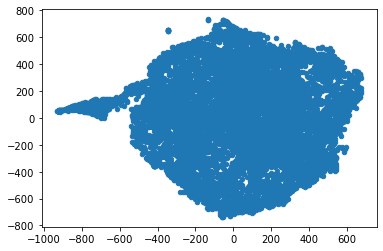

In [59]:
print("Running graph for individual artist similarities")

Y = tsne(X_artists, 2, 50, 20.0)
pylab.scatter(Y[:, 0], Y[:, 1], 20)
#pylab.xlabel(artist_labels)
pylab.show()


### Coded by decade

Running graph for artist similarities coded by half decade
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 6658...
Computing P-values for point 500 of 6658...
Computing P-values for point 1000 of 6658...
Computing P-values for point 1500 of 6658...
Computing P-values for point 2000 of 6658...
Computing P-values for point 2500 of 6658...
Computing P-values for point 3000 of 6658...
Computing P-values for point 3500 of 6658...
Computing P-values for point 4000 of 6658...
Computing P-values for point 4500 of 6658...
Computing P-values for point 5000 of 6658...
Computing P-values for point 5500 of 6658...
Computing P-values for point 6000 of 6658...
Computing P-values for point 6500 of 6658...
Mean value of sigma: 1.015442
Iteration 10: error is 27.616775
Iteration 20: error is 27.387197
Iteration 30: error is 24.616558
Iteration 40: error is 23.432916
Iteration 50: error is 23.222963
Iteration 60: error is 23.150721
Iteration 70: error

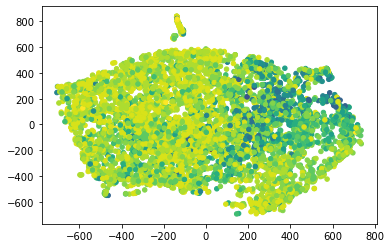

In [60]:
print("Running graph for artist similarities coded by half decade")

Y = tsne(X, 2, 50, 20.0)
pylab.scatter(Y[:, 0], Y[:, 1], 20,labels)
pylab.show()


### Coded by decade 1,000 samples

In [61]:
reduced_dfm = df_byart_fm.sample(2000)
reduced_X_df = reduced_dfm.drop(['artist_id','total_terms','year','year','decade'],axis=1)
reduced_labels_df = reduced_dfm[['decade']]
reduced_X = reduced_X_df.to_numpy()
reduced_labels = reduced_labels_df.to_numpy()

Running graph for REDUCED artist similarities coded by half decade
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 1.164527
Iteration 10: error is 22.702631
Iteration 20: error is 20.397003
Iteration 30: error is 19.236434
Iteration 40: error is 19.262492
Iteration 50: error is 19.435676
Iteration 60: error is 19.501481
Iteration 70: error is 19.486698
Iteration 80: error is 19.469543
Iteration 90: error is 19.469035
Iteration 100: error is 19.471759
Iteration 110: error is 3.054704
Iteration 120: error is 2.577823


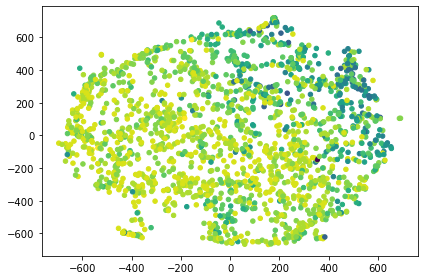

In [73]:
print("Running graph for REDUCED artist similarities coded by half decade")

Y = tsne(reduced_X, 2, 50, 20.0)
pylab.scatter(Y[:, 0], Y[:, 1], 20,reduced_labels)
#pylab.legend(reduced_labels,bbox_to_anchor=(1.05, 1), loc='upper left',borderaxespad=0)
pylab.tight_layout()


### Top 100 Genres

Running graph for artist similarities coded by half decade
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 6658...
Computing P-values for point 500 of 6658...
Computing P-values for point 1000 of 6658...
Computing P-values for point 1500 of 6658...
Computing P-values for point 2000 of 6658...
Computing P-values for point 2500 of 6658...
Computing P-values for point 3000 of 6658...
Computing P-values for point 3500 of 6658...
Computing P-values for point 4000 of 6658...
Computing P-values for point 4500 of 6658...
Computing P-values for point 5000 of 6658...
Computing P-values for point 5500 of 6658...
Computing P-values for point 6000 of 6658...
Computing P-values for point 6500 of 6658...
Mean value of sigma: 0.929503
Iteration 10: error is 27.541557
Iteration 20: error is 27.266189
Iteration 30: error is 25.190382
Iteration 40: error is 23.558679
Iteration 50: error is 23.093031
Iteration 60: error is 23.104105
Iteration 70: error

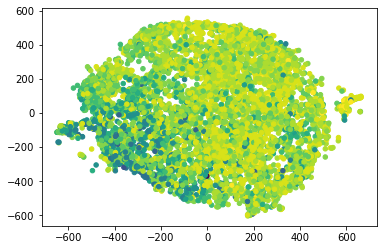

In [72]:
print("Running graph for artist similarities coded by half decade")

Y = tsne(X_100, 2, 50, 20.0)
pylab.scatter(Y[:, 0], Y[:, 1], 20,labels)
pylab.show()
